<a href="https://colab.research.google.com/github/Maternowsky/Maternowsky/blob/main/Mechanics_of_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Key features of PyTorch**

## **Computational Graphs**

In [1]:
import torch
def compute_z(a,b,c):
  r1 = torch.sub(a,b)
  r2 = torch.mul(r1, 2)
  z = torch.add(r2, c)
  return z

In [2]:
print('Scaler Inputs:', compute_z(torch.tensor(1), torch.tensor(2),
                                  torch.tensor(3)))

Scaler Inputs: tensor(1)


In [3]:
print('Rank 1 Inputs:', compute_z(torch.tensor([1]), torch.tensor([2]),
                                  torch.tensor([3])))

Rank 1 Inputs: tensor([1])


In [4]:
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]),
                                   torch.tensor([[3]])))

Rank 2 Inputs: tensor([[1]])


# **Tensor object for storing and updating model parameters**

In [5]:
a = torch.tensor(3.14, requires_grad = True)
print(a)

tensor(3.1400, requires_grad=True)


In [6]:
b = torch.tensor([1.0,2.0,3.0], requires_grad= True)
print(b)

tensor([1., 2., 3.], requires_grad=True)


In [7]:
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)

False


In [8]:
w.requires_grad_()
print(w.requires_grad)

True


## **Create empty tensor, fill tensor with values according to Glorot initialization**

In [9]:
import torch.nn as nn
torch.manual_seed(1)
w = torch.empty(2,3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


## **define two Tensor objects inside the base nn.Module class**

In [10]:
class MyModule(nn.Module):
  def __init__(self):
    super().__init__()
    self.w1 = torch.empty(2,3, requires_grad = True)
    nn.init.xavier_normal_(self.w1)
    self.w2 = torch.empty(1,2, requires_grad=True)
    nn.init.xavier_normal_(self.w2)

### **Computing gradients via automatic differentiation**

In [11]:
w = torch.tensor(1.0, requires_grad= True)
b = torch.tensor(0.5, requires_grad= True)
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w,x),b)
loss = (y-z).pow(2).sum()
loss.backward()
print('dL/dw : ', w.grad)
print('dL/db : ', b.grad)

dL/dw :  tensor(-0.5600)
dL/db :  tensor(-0.4000)


In [12]:
#verifying the computed gradient
print(2 * x * ((w * x + b)-y))

tensor([-0.5600], grad_fn=<MulBackward0>)


### **Adversarial examples - adding some smalle imperceptible noise to inpute example, which results in deep NN misclassifying them**

# **Simplifying implementations of common architectures via the torch.nn module**

## **Models based on nn.Sequential**

In [13]:
model = nn.Sequential(nn.Linear(4,16),
                      nn.ReLU(),
                      nn.Linear(16,32),
                      nn.ReLU())
model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

### **Configure first fully connected layer by specifying initial value distribution for weight. Configure second fully connected layer by computing the L1 penalty term for the weight matix**

In [14]:
nn.init.xavier_uniform_(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

### **Choosing a loss function- for this function we will use SGD optimizer, and cross-entropy loss for binary classification**

In [15]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# **Solving an XOR classification problem**

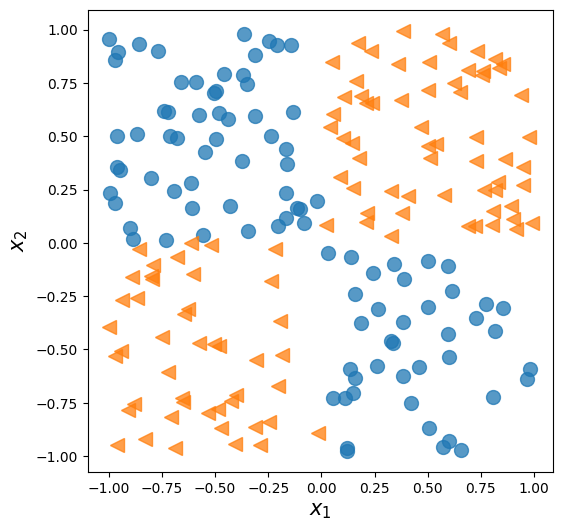

In [16]:
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)
np.random.seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1] < 0] = 0
n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype = torch.float32)
y_train = torch.tensor(y[:n_train], dtype = torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype = torch.float32)
y_valid = torch.tensor(y[n_train:], dtype = torch.float32)
fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], x[y==0, 1], 'o', alpha = 0.75, markersize = 10)
plt.plot(x[y==1, 0], x[y==1, 1], '<', alpha = 0.75, markersize = 10)
plt.xlabel(r'$x_1$', size = 15)
plt.ylabel(r'$x_2$', size = 15)
plt.show()

## **Starting with simple single-layer NN**

In [17]:
model = nn.Sequential(nn.Linear(2,1), nn.Sigmoid())
model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [18]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

In [19]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)


In [20]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

### **Plot Performance**

Text(0.5, 0, 'Epochs')

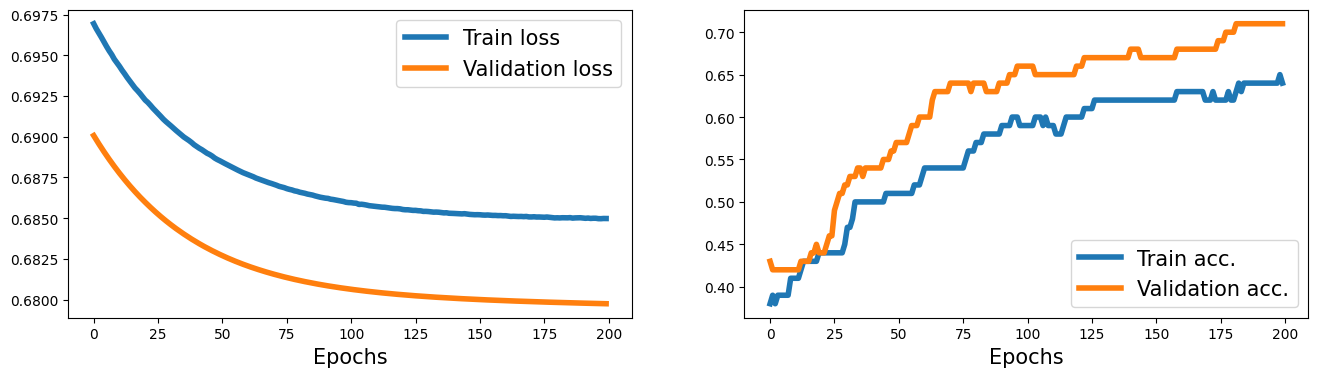

In [21]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

## **NN with two hidden layers**

In [22]:
model = nn.Sequential(nn.Linear(2,4),
                      nn.ReLU(),
                      nn.Linear(4,4),
                      nn.ReLU(),
                      nn.Linear(4,1),
                      nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [23]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [24]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

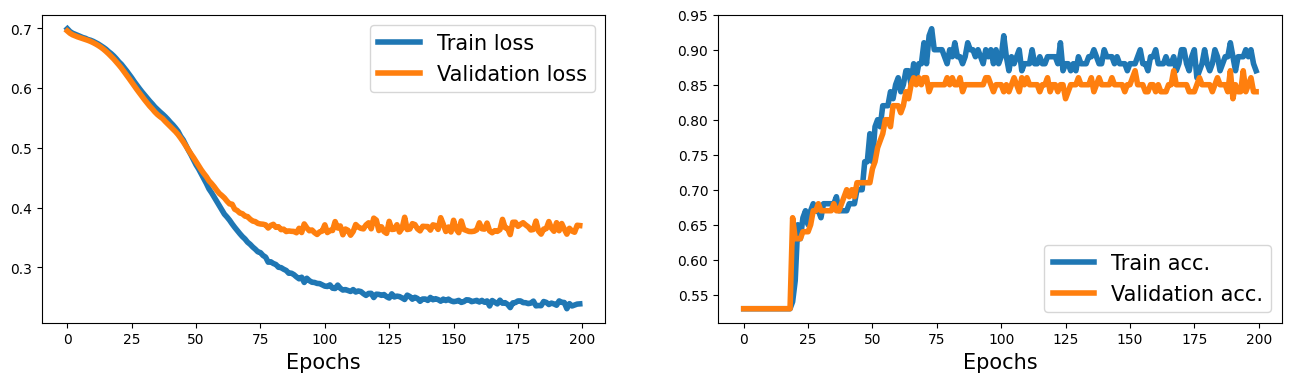

In [25]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

## **Adding more layers**

In [26]:
model = nn.Sequential(nn.Linear(2,4),
                      nn.ReLU(),
                      nn.Linear(4,4),
                      nn.ReLU(),
                      nn.Linear(4,4),
                      nn.ReLU(),
                      nn.Linear(4,4),
                      nn.ReLU(),
                      nn.Linear(4,1),
                      nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=4, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=4, bias=True)
  (7): ReLU()
  (8): Linear(in_features=4, out_features=1, bias=True)
  (9): Sigmoid()
)

In [27]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [28]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

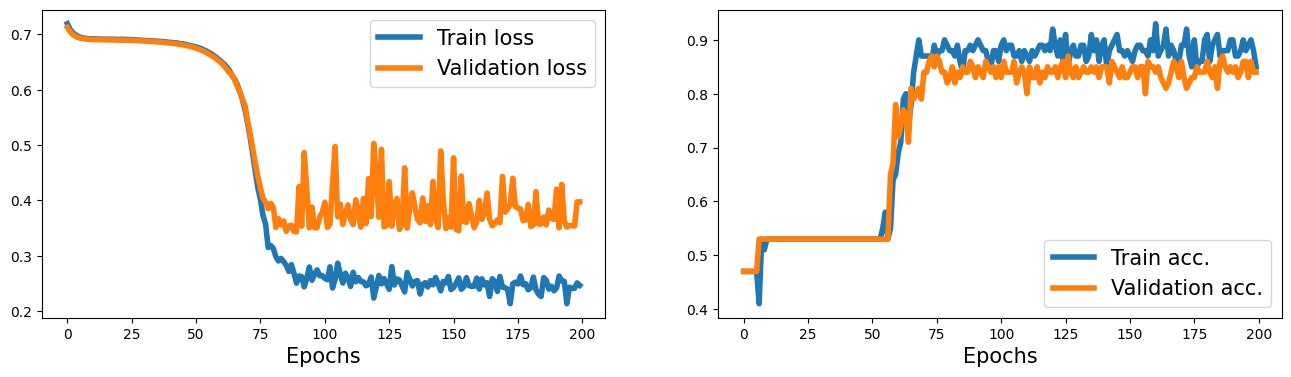

In [29]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

## **Testing wider model to see results**

In [30]:
model = nn.Sequential(nn.Linear(2,4),
                      nn.ReLU(),
                      nn.Linear(4,8),
                      nn.ReLU(),
                      nn.Linear(8,12),
                      nn.ReLU(),
                      nn.Linear(12,8),
                      nn.ReLU(),
                      nn.Linear(8,1),
                      nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=12, bias=True)
  (5): ReLU()
  (6): Linear(in_features=12, out_features=8, bias=True)
  (7): ReLU()
  (8): Linear(in_features=8, out_features=1, bias=True)
  (9): Sigmoid()
)

In [31]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [32]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

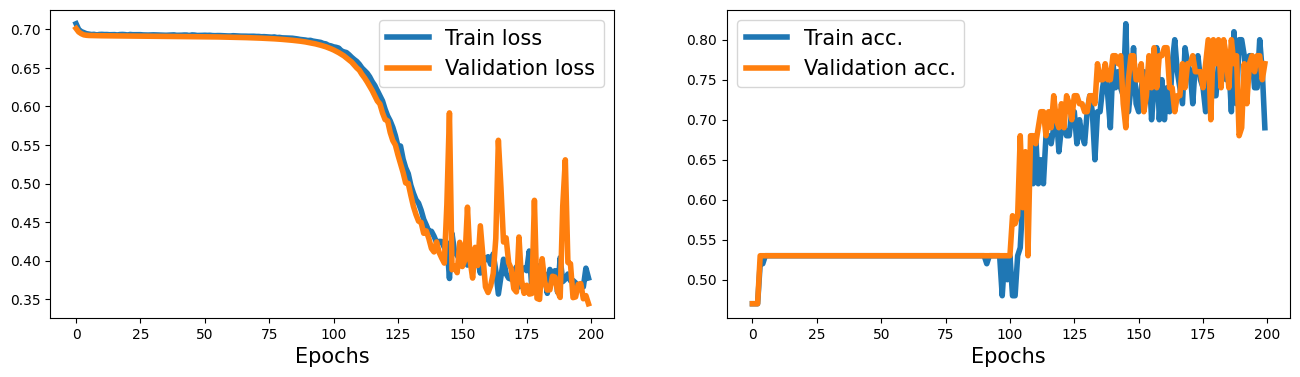

In [33]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

## **Simple deeper model**

In [34]:
model = nn.Sequential(nn.Linear(2,2),
                      nn.ReLU(),
                      nn.Linear(2,2),
                      nn.ReLU(),
                      nn.Linear(2,2),
                      nn.ReLU(),
                      nn.Linear(2,2),
                      nn.ReLU(),
                      nn.Linear(2,1),
                      nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=2, bias=True)
  (5): ReLU()
  (6): Linear(in_features=2, out_features=2, bias=True)
  (7): ReLU()
  (8): Linear(in_features=2, out_features=1, bias=True)
  (9): Sigmoid()
)

In [35]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [36]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

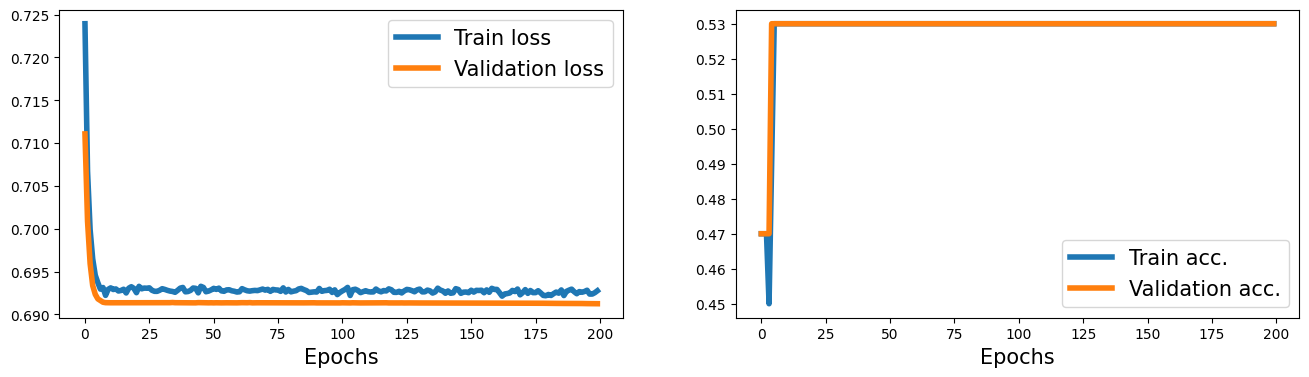

In [37]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

In [38]:
model = nn.Sequential(nn.Linear(2,4),
                      nn.ReLU(),
                      nn.Linear(4,8),
                      nn.ReLU(),
                      nn.Linear(8,8),
                      nn.ReLU(),
                      nn.Linear(8,1),
                      nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=1, bias=True)
  (7): Sigmoid()
)

In [39]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [40]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

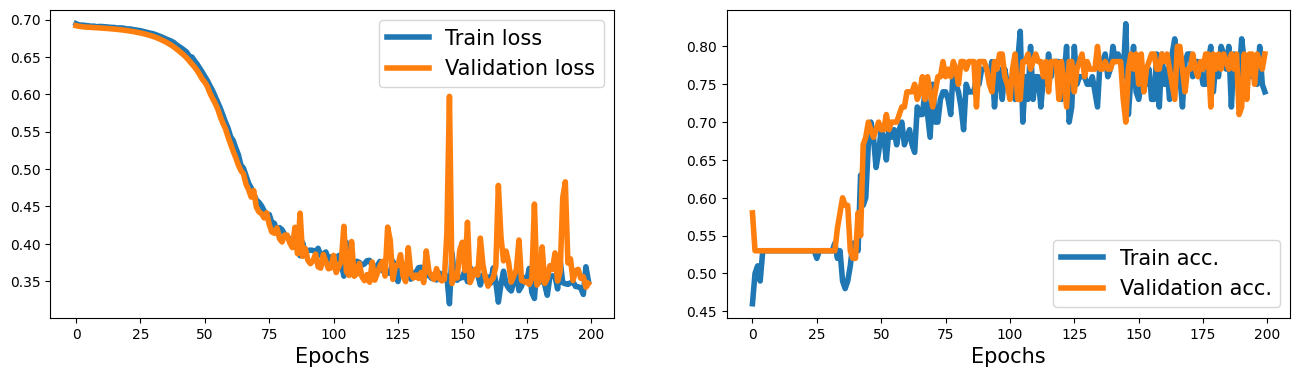

In [41]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

In [42]:
model = nn.Sequential(nn.Linear(2,8),
                      nn.ReLU(),
                      nn.Linear(8,8),
                      nn.ReLU(),
                      nn.Linear(8,1),
                      nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=1, bias=True)
  (5): Sigmoid()
)

In [43]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [44]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

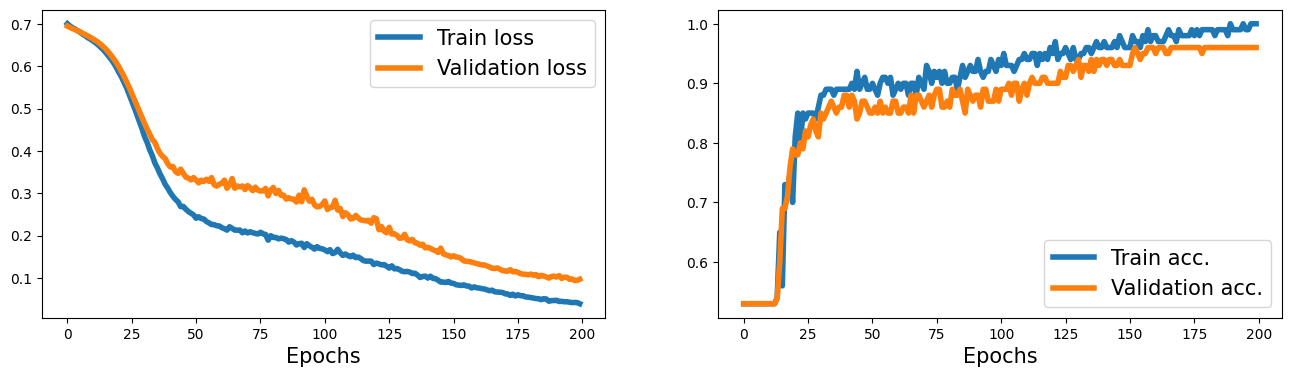

In [45]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

In [46]:
model = nn.Sequential(nn.Linear(2,10),
                      nn.ReLU(),
                      nn.Linear(10,10),
                      nn.ReLU(),
                      nn.Linear(10,1),
                      nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)

In [47]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [48]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

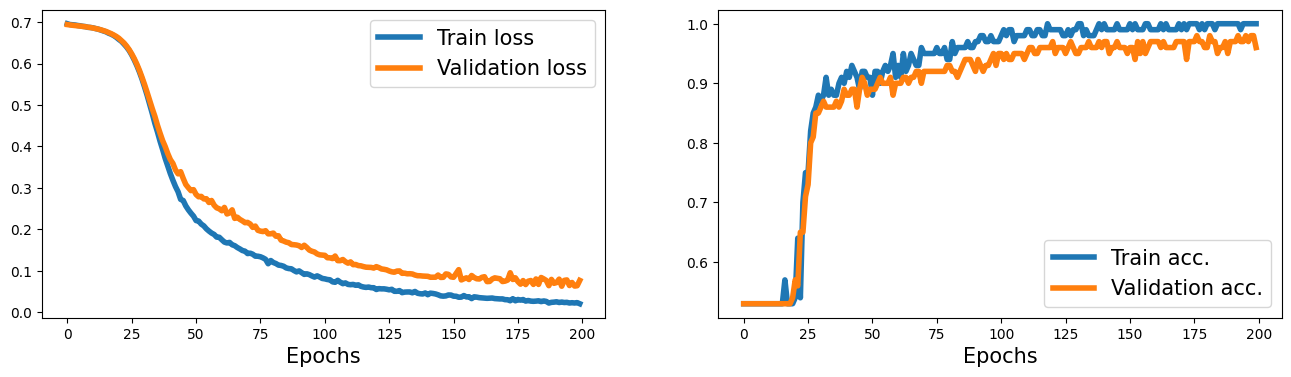

In [49]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

In [50]:
model = nn.Sequential(nn.Linear(2,8),
                      nn.ReLU(),
                      nn.Linear(8,10),
                      nn.ReLU(),
                      nn.Linear(10,1),
                      nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=1, bias=True)
  (5): Sigmoid()
)

In [51]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [52]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

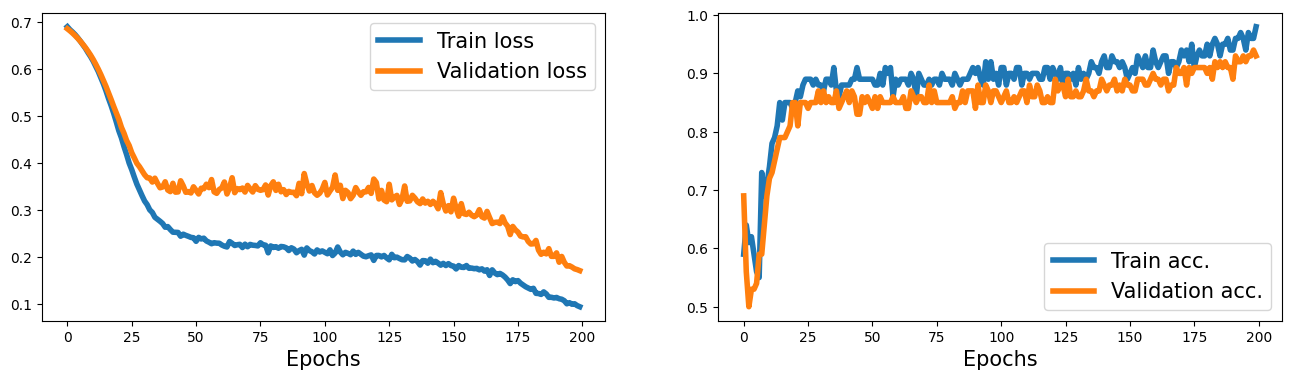

In [53]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

In [54]:
model = nn.Sequential(nn.Linear(2,8),
                      nn.ReLU(),
                      nn.Linear(8,8),
                      nn.ReLU(),
                      nn.Linear(8,8),
                      nn.ReLU(),
                      nn.Linear(8,1),
                      nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=8, bias=True)
  (5): ReLU()
  (6): Linear(in_features=8, out_features=1, bias=True)
  (7): Sigmoid()
)

In [55]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [56]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

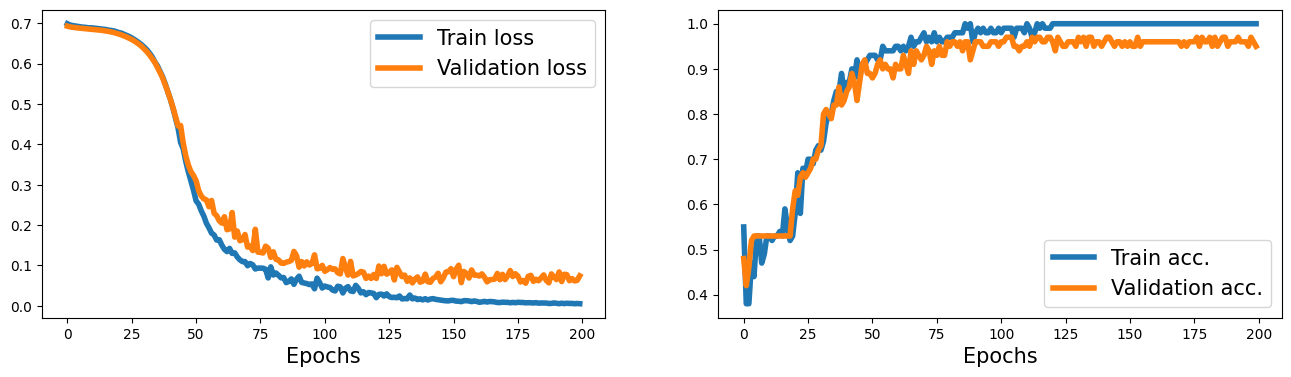

In [57]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

In [58]:
model = nn.Sequential(nn.Linear(2,20),
                      nn.ReLU(),
                      nn.Linear(20,20),
                      nn.ReLU(),
                      nn.Linear(20,1),
                      nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): ReLU()
  (4): Linear(in_features=20, out_features=1, bias=True)
  (5): Sigmoid()
)

In [59]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [60]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

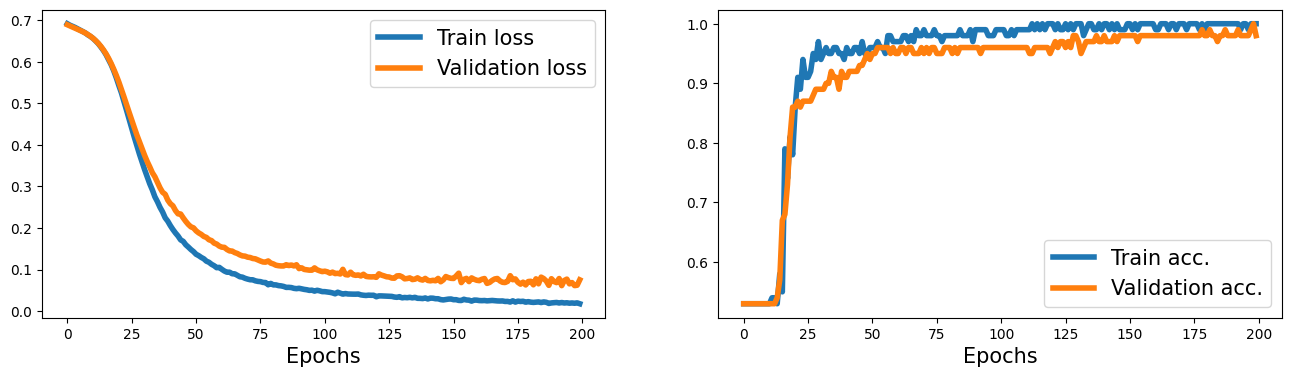

In [61]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

In [62]:
model = nn.Sequential(nn.Linear(2,20),
                      nn.ReLU(),
                      nn.Linear(20,1),
                      nn.Sigmoid())
loss_fn = nn.BCELoss()
optimizer= torch.optim.SGD(model.parameters(), lr = 0.015)
model

Sequential(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1): ReLU()
  (2): Linear(in_features=20, out_features=1, bias=True)
  (3): Sigmoid()
)

In [63]:
from torch.utils.data import DataLoader, TensorDataset
train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [64]:
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
  loss_hist_train = [0] * num_epochs
  accuracy_hist_train = [0] * num_epochs
  loss_hist_valid = [0] * num_epochs
  accuracy_hist_valid = [0] * num_epochs
  for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
      pred = model(x_batch)[:, 0]
      loss = loss_fn(pred, y_batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      loss_hist_train[epoch] += loss.item()
      is_correct = ((pred>=0.5).float() == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    accuracy_hist_train[epoch] /= n_train/batch_size
    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred > 0.5).float()== y_valid).float()
    accuracy_hist_valid[epoch] += is_correct.mean()
  return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

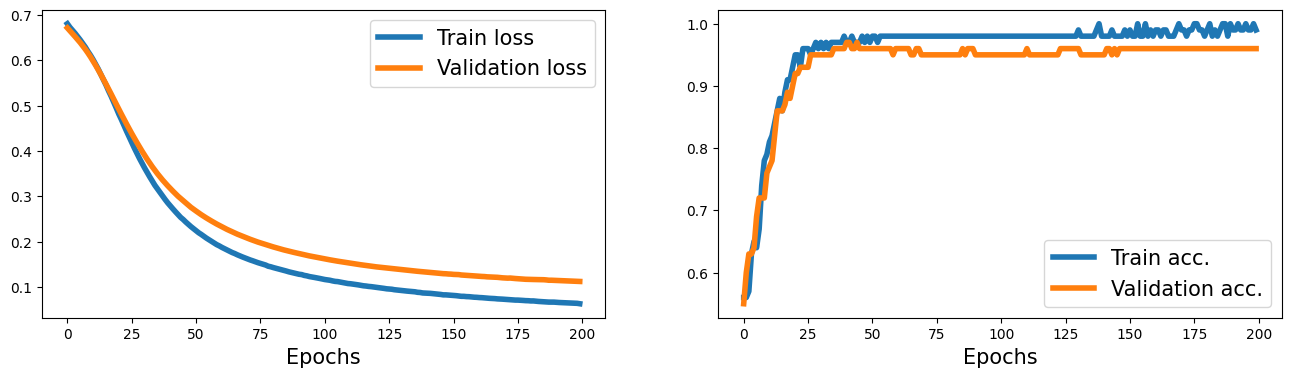

In [65]:
fig = plt.figure(figsize = (16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,2,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)

### **After playing with the layers and layer width using the sequential model. It seems that a shallow but wider model was the best i could find.**

## **Model building with nn.Module**

In [70]:
class MyModule(nn.Module):
  def __init__(self):
    super().__init__()
    l1 = nn.Linear(2,4)
    a1 = nn.ReLU()
    l2 = nn.Linear(4,4)
    a2 = nn.ReLU()
    l3 = nn.Linear(4,1)
    a3 = nn.Sigmoid()
    l = [l1, a1, l2, a2, l3, a3]
    self.module_list = nn.ModuleList(l)

  def forward(self, x):
    for f in self.module_list:
      x = f(x)
    return x
  def predict(self, x):
    x = torch.tensor(x, dtype = torch.float32)
    pred = self.forward(x)[:, 0]
    return (pred>=0.5).float()
    
    

In [71]:
model = MyModule()
model

MyModule(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [72]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

### **Plot decision boundaries with mlxtend**

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


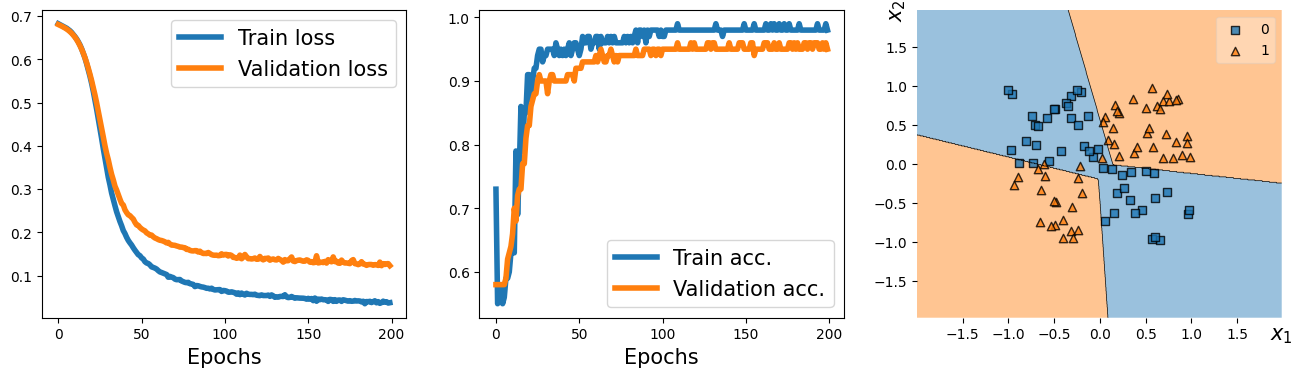

In [73]:
%pip install mlxtend --upgrade
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,3,1)
plt.plot(history[0], lw = 4)
plt.plot(history[1], lw = 4)
plt.legend(['Train loss', 'Validation loss'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,3,2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw = 4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize = 15)
ax.set_xlabel('Epochs', size = 15)
ax = fig.add_subplot(1,3,3)
plot_decision_regions(X = x_valid.numpy(),
                      y = y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size = 15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size = 15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

# **Custom layer in PyTorch**

In [74]:
class NoisyLinear(nn.Module):
  def __init__(self, input_size, output_size, noise_stddev=0.1):
    super().__init__()
    w = torch.Tensor(input_size, output_size)
    self.w = nn.Parameter(w) #is a tensor
    nn.init.xavier_uniform_(self.w)
    b = torch.Tensor(output_size).fill_(0)
    self.b = nn.Parameter(b)
    self.noise_stddev = noise_stddev
  
  def forward(self, x, training = False):
    if training:
      noise = torch.normal(0.0, self.noise_stddev, x.shape)
      x_new = torch.add(x, noise)
    else:
      x_new = x
    return torch.add(torch.mm(x_new, self.w), self.b)

In [75]:
torch.manual_seed(1)
noisy_layer = NoisyLinear(4,2)
x = torch.zeros((1,4))
print(noisy_layer(x, training = True))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)


In [76]:
print(noisy_layer(x, training = True))

tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)


In [77]:
print(noisy_layer(x, training = False))

tensor([[0., 0.]], grad_fn=<AddBackward0>)


## **New model with noisy linear layer. solving the XOR problem**

In [78]:
class MyNoisyModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()
        
    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred>=0.5).float()

torch.manual_seed(1)
model = MyNoisyModule()
model


MyNoisyModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [79]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.015)
torch.manual_seed(1)
loss_hist_train = [0] * num_epochs
accuracy_hist_train = [0] * num_epochs
loss_hist_valid = [0] * num_epochs
accuracy_hist_valid = [0] * num_epochs

for epoch in range(num_epochs):
  for x_batch, y_batch in train_dl:
    pred = model(x_batch, True)[:, 0]
    loss = loss_fn(pred, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_hist_train[epoch] += loss.item()
    is_correct = ((pred>= 0.5).float() == y_batch).float()
    accuracy_hist_train[epoch] += is_correct.mean()

  loss_hist_train[epoch]/= n_train/batch_size
  accuracy_hist_train[epoch] /= n_train/batch_size

  pred = model(x_valid)[:, 0]
  loss = loss_fn(pred, y_valid)
  loss_hist_valid[epoch] = loss.item()
  is_correct = ((pred>=0.5).float() == y_valid).float()
  accuracy_hist_valid[epoch] += is_correct.mean()

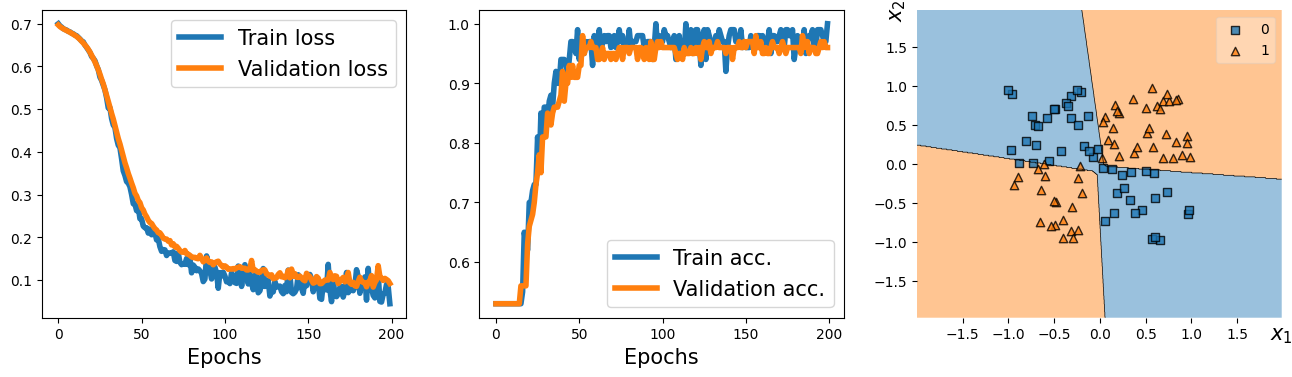

In [80]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(accuracy_hist_train, lw=4)
plt.plot(accuracy_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

plt.show()